# Libraries

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
from torch.optim import Adam
import torch.nn.functional as F
import numpy as np

# for teacher
import random

from sklearn.model_selection import train_test_split

# Side variables
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
base_type = np.float32
torch_type = torch.float32
batch_size = 32
window_length = 1024 # Data points will hold 1024 tokens of observations (should be 1/4 average song length in tokens, remember to remove outliers)
window_step_size = 32 # Sliding window will move this much each time (higher numbers means less data, but less overfitting to similar data)


Using device: cuda


# Load Data / Tokenize

In [3]:
# load
data = []
with open("./out.txt", "r") as file:
    data = file.read().splitlines()

print(data[5:10])

['<simul>', 'rest_1/2', 'noteD3_1/2', '</simul>', '<simul>']


In [4]:
# now tokenize
unique_tokens = set(list(data) + ["PAD"])
print(len(unique_tokens))
# mapping
note_to_token = {note: idx for idx, note in enumerate(unique_tokens)}
token_to_note = {idx: note for note, idx in note_to_token.items()}


4195


# Data Preprocessing

In [4]:
end_token = note_to_token["<end_song>"]
pad_token = note_to_token["PAD"]
print(end_token)
print(pad_token)

595
3983


In [5]:
data_inp = [note_to_token[tok] for tok in data]


# Assume already tokenized (this is for transformer, must be adapted for other models)
class MusicDataset(Dataset):
    def __init__(self, data, window_length, step_size):
        self.temp_data = data
        self.window_length = window_length
        self.step_size = step_size
        self.final_data = self.apply_window()

    def apply_window(self):
        train_examples = []
        song_data = []
        cur_seq = []

        # first split data by songs
        for tok in self.temp_data:
            cur_seq.append(tok)
            if(tok == end_token):
                song_data.append(cur_seq)
                cur_seq = []
        
        # then apply sliding windows
        for song in song_data:
            idx = 0
            # create sliding windows
            for start_idx in range(0, len(song) - self.window_length + 1, self.step_size):
                end_idx = start_idx + self.window_length
                idx = end_idx # store most recent end_idx
                train_example = song[start_idx:end_idx] # training of length window_length
                train_examples.append(train_example)
            
            # now add ending and pad (so model can learn how to finish predicting)
            train_example = song[idx:]
            train_example += [0] * (self.window_length - len(train_example))
            train_examples.append(train_example)


        return train_examples

    #def apply_window(self):
    #    # return sliding window data + labels
    #    train_examples = []
    #    # cycle through each window configuration, calculating start index and end index
    #    for start_idx in range(0, len(self.temp_data) - self.window_length + 1, self.step_size):
    #        end_idx = start_idx + self.window_length
    #        train_example = self.temp_data[start_idx:end_idx] # training of length window_length
    #        train_examples.append(train_example)
    #        
    #    return train_examples
    
                

    def __len__(self):
        return len(self.final_data)

    def __getitem__(self, idx):
        window = self.final_data[idx]

        return torch.tensor(window).to(device)
    

dataset = MusicDataset(data_inp, window_length, window_step_size)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

training_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

vocab_len = len(unique_tokens)


In [6]:
# generate music
# for now, generate a fixed length, if we add start and end tokens then we can also do that
def generate_music(model, start_tokens, temperature=1.0, num_to_generate=window_length):
    model.eval()

    predicted_tokens = torch.tensor(start_tokens).clone().detach().unsqueeze(0) # (1, len(start_tokens))
    # iteratively predict then add to start_tokens
    for i in range(num_to_generate):
        with torch.no_grad():
            # grab most recent tokens
            logits = model(predicted_tokens[:, -(window_length):]) # (1, len(predicted_tokens), num_tokens)
            logits = logits[:, -1, :] # grabs last token 
            probs = torch.softmax(logits / temperature, dim=-1) # (1, num_tokens)
            pred_token = torch.multinomial(probs, num_samples=1) # (1, 1)

        predicted_tokens = torch.cat([predicted_tokens, pred_token], dim=1) # (1, len(current sequence length))

    return predicted_tokens.squeeze(0).tolist()


In [7]:
from matplotlib import pyplot as plt
def Display_Plot(train_loss, valid_loss, model_name):
    # Get error metrics
    train_err = np.array(train_loss)
    val_err = np.array(valid_loss)
    # Plot training and test errors
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(train_err) + 1), train_err, label="train_loss", color="red", linewidth=2)
    plt.plot(range(1, len(val_err) + 1), val_err, label="val_loss", color="green", linewidth=2)

    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.title(model_name)
    plt.legend()

    plt.show()

# RNN

In [14]:
# RNN Variables
input_size = 256
hidden_size = 512 # larger embed size may require larger dropout
dropout = 0.2
lr = 1e-4
epochs = 20

In [15]:
class Music_RNN(nn.Module):
    def __init__(self, vocab_len, input_size, hidden_size, dropout):
        super(Music_RNN, self).__init__()
        self.embed = nn.Embedding(vocab_len, input_size)
        self.RNN = nn.RNN(input_size, hidden_size, batch_first=True, num_layers=2, dropout=dropout)
        self.layernorm = nn.LayerNorm(hidden_size)
        self.drop = nn.Dropout(dropout)
        self.ff = nn.Linear(hidden_size, vocab_len) # predicting next input autoregressively

    def forward(self, x):
        # x should be (batch_size, seq_len)
        x = self.embed(x) # (batch_size, seq_len, input_size)
        x, _ = self.RNN(x) # (batch_size, seq_len, hidden_size)
        x = self.layernorm(x)
        x = self.drop(x)
        x_pred = self.ff(x) # batch_size, seq_len, vocab_len)

        return x_pred 

In [16]:
model_rnn = Music_RNN(vocab_len, input_size, hidden_size, dropout).to(device)

In [ ]:
# adapt loss and optimizer as needed
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model_rnn.parameters(), lr=lr)

train_losses = []
valid_losses = []

# train
for epoch in range(epochs):
    # Set to train
    model_rnn.train()
    # keep cumalitive losses
    total_losses = 0.0

    for batch in training_dataloader:
        inp = batch[:, :-1] # grabs all but last
        tgt = batch[:, 1:] # grabs all except first (shifted once)

        optimizer.zero_grad()

        preds = model_rnn.forward(inp) # make sure dimensions line up

        loss = criterion(preds.view(-1, vocab_len), tgt.reshape(-1))
        loss.backward()

        optimizer.step()

        total_losses += loss.item()

    train_losses.append(total_losses / len(training_dataloader))
    print(f"Epoch: {epoch}, Loss: {total_losses / len(training_dataloader)}")


    # Validation
    model_rnn.eval()

    total_valid_losses = 0.0

    with torch.no_grad():
        for batch in validation_dataloader:
            inp = batch[:, :-1] # grabs all but last
            tgt = batch[:, 1:] # grabs all except first (shifted once)

            preds = model_rnn.forward(inp) # make sure dimensions line up

            loss = criterion(preds.view(-1, vocab_len), tgt.reshape(-1))
            total_valid_losses += loss.item()

    valid_losses.append(total_valid_losses / len(validation_dataloader))
    print(f"Validation loss: {total_valid_losses / len(validation_dataloader)}")


Display_Plot(train_loss=train_losses, valid_loss=valid_losses, model_name="RNN Music")


Epoch: 0, Loss: 3.9345018919285812
Validation loss: 3.1780834710875223
Epoch: 1, Loss: 3.0181748175412504
Validation loss: 2.7481323951898617
Epoch: 2, Loss: 2.7412663263760226
Validation loss: 2.5505862845930944


In [12]:
# this just grabs a random batch and performs on it
for batch in validation_dataloader:
    bleh = generate_music(model_rnn, batch[0][:4], temperature=1.0)
    notes = [token_to_note[token] for token in bleh]
    print(print(notes))
    break

/tmp/ipykernel_867693/2880647662.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_tokens = torch.tensor(start_tokens).clone().detach().unsqueeze(0) # (1, len(start_tokens))


['<simul>', 'noteG4_1/4', 'noteG3_1/2', '</simul>', '<simul>', 'noteC5_3/8', 'noteA3_1/2', '</simul>', '<simul>', 'noteC5_1/2', 'noteF3_1/2', '</simul>', '<simul>', 'noteG3_1/2', 'noteC4_1/2', '</simul>', '<simul>', 'noteC#3_1/2', 'noteG3_1/2', '</simul>', '<simul>', 'noteF#4_1/2', 'noteF#3_1/2', '</simul>', '<simul>', 'noteC5_1/2', 'noteC4_1/2', '</simul>', 'noteE4_1/4', '<simul>', 'noteG4_1/2', 'noteD3_1/2', '</simul>', 'noteE5_1/2', '<simul>', 'noteB4_1/2', 'noteC5_1/2', 'rest_5/2', '</simul>', '<simul>', 'noteF#5_2', 'noteE-4_1/2', '</simul>', 'noteC#5_1/4', '<simul>', 'noteE-6_1/4', 'rest_1', '</simul>', 'noteC#6_1/4', '<simul>', 'noteC6_1/4', 'noteD6_1/4', '</simul>', 'noteE-5_1/4', '<simul>', 'noteE-6_1/4', 'noteD5_1/2', '</simul>', '</simul>', '<simul>', 'noteA5_1/4', 'noteE5_1/4', 'noteE6_1/4', '</simul>', '<simul>', 'noteG5_1/4', 'noteA4_1/4', 'noteA3_1/4', '</simul>', '<simul>', 'noteF4_1/8', 'noteE5_1/4', 'noteB4_1/4', '</simul>', '<simul>', 'noteC6_1/4', 'rest_1/4', '</sim

In [13]:
torch.save(model_rnn.state_dict(), "music_rnn_model.pth")

# LSTM

# Transformer

YAYYYYYYYYY Transformer Time WOOOOOOOOO

In [8]:
#  Model variables
d_model = 128 # Embed Dim
n_decoder_layers = 8 # lower if not that complex and wanting speedup
n_heads = 8 # Number of Attention Heads
d_ff = 512 # Feed Forward Dimensionality (AIAYN paper reccomends 4 times d_model size)
learning_rate = 1e-4 # Maybe increase?
num_epochs = 30 # Change this later so it doesn't take 10 years to run

In [9]:
# Standard positonal encoding used here, could also try time encoding since notes have different timestamps
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, win_len):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(win_len, d_model) # (win_len, d_model)
        position = torch.arange(0, win_len, dtype=torch_type).unsqueeze(1) # (win_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float()*(-torch.log(torch.tensor(10000.0))/d_model)) # (d_model/2)
        pe[:, 0::2] = torch.sin(position*div_term)
        pe[:, 1::2] = torch.cos(position*div_term)
        pe = pe.unsqueeze(0) # (1, win_len, d_model)
        self.pe = pe.to(device)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x


# mask
def generate_causal_mask(size):
    # size should be target size
    mask = torch.triu(torch.ones(size, size, device=device), diagonal=1)
    mask = mask.masked_fill(mask == 1, float('-inf'))
    '''
    [0, -inf, -inf, -inf]
    [0,   0,  -inf, -inf]
    [0,   0,    0,  -inf]
    [0,   0,    0,    0 ]
    Yay for triangle masking
    '''
    return mask


In [10]:
# Actual decoder
class MusicTransformer(nn.Module):
    def __init__(self, num_tokens, d_model=d_model, nhead=n_heads, dim_ff=d_ff, win_len=window_length, layers=n_decoder_layers):
        super(MusicTransformer, self).__init__()
        self.d_model = d_model
        self.nheads = nhead
        self.dim_ff = dim_ff
        self.win_len = win_len
        self.layers = layers

        # pre-transformer
        self.tok_embed = nn.Embedding(num_tokens, d_model)
        self.pos_enc = PositionalEncoding(d_model, win_len)
        self.out_proj = nn.Linear(d_model, num_tokens) # final projection for token prediction

        # transformer part
        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_ff, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=self.layers)


    def forward(self, x, tgt_mask=None):
        '''
        x is the tokenized notes  # (batch_size, win_len)
        tgt_mask masks the predictions
        '''

        x_seq = self.tok_embed(x) # (batch_size, 1, d_model)
        x_seq = self.pos_enc(x_seq) # (batch_size, 1, d_model)

        decoder_output = self.decoder(x_seq, x_seq, tgt_mask=tgt_mask) # (batch_size, win_len, d_model)
        pred = self.out_proj(decoder_output) # (batch, win_len, num_tokens) 
      
        return pred



Epoch: [1/30]   Epoch Average Loss: 4.810683313681155
Validation Loss: 4.048098774843438
Epoch: [2/30]   Epoch Average Loss: 3.8210270456948017
Validation Loss: 3.587514184242071
Epoch: [3/30]   Epoch Average Loss: 3.5029922275431997
Validation Loss: 3.3517718218093693
Epoch: [4/30]   Epoch Average Loss: 3.296694729835577
Validation Loss: 3.1437740325927734
Epoch: [5/30]   Epoch Average Loss: 3.1002397811795115
Validation Loss: 2.9561192850733913
Epoch: [6/30]   Epoch Average Loss: 2.939703649404098
Validation Loss: 2.806815740674041
Epoch: [7/30]   Epoch Average Loss: 2.805984321558093
Validation Loss: 2.674182098965312
Epoch: [8/30]   Epoch Average Loss: 2.68709786258008
Validation Loss: 2.551891703938329
Epoch: [9/30]   Epoch Average Loss: 2.578559364591326
Validation Loss: 2.4392667052357697
Epoch: [10/30]   Epoch Average Loss: 2.4790432126459505
Validation Loss: 2.3372261898462163
Epoch: [11/30]   Epoch Average Loss: 2.3920088419066228
Validation Loss: 2.2467132827570273
Epoch: [1

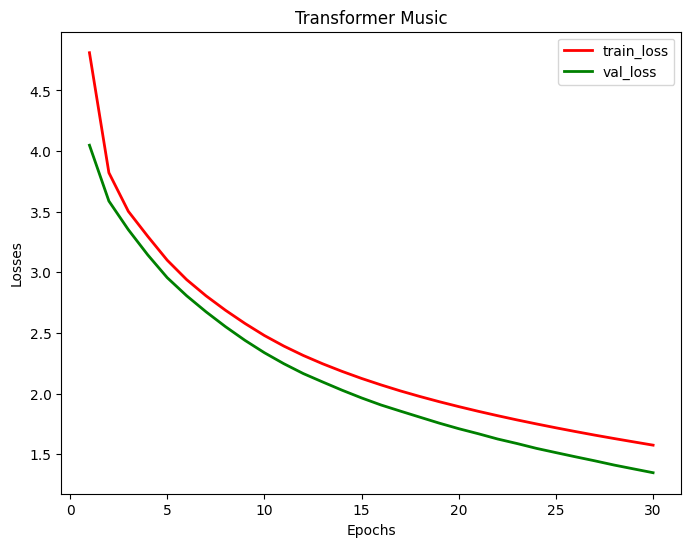

In [11]:
my_mask = generate_causal_mask(window_length) # win_len by win_len mask

# Create model
num_tokens = vocab_len
model = MusicTransformer(num_tokens, d_model, n_heads, d_ff, window_length, n_decoder_layers).to(device)

# Use Adam cause he's so cool
optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

transformer_train_losses = []
transformer_valid_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0 # cumalative loss

    # Cycle through each batch
    for batch in training_dataloader:
        inp = batch[:, :-1] # grabs all but last
        tgt = batch[:, 1:] # grabs all except first (shifted once)


        optimizer.zero_grad()
        # Pass through model
        output = model(inp)
        # Determine loss
        loss = criterion(output.contiguous().view(-1, num_tokens), tgt.reshape(-1))
        # Update weights
        loss.backward()
        optimizer.step()
        # Add to epoch_loss
        epoch_loss += loss.item()

    # Now show average loss for epoch
    avg_epoch_loss = epoch_loss / len(training_dataloader)
    transformer_train_losses.append(avg_epoch_loss)
    print(f"Epoch: [{epoch+1}/{num_epochs}]   Epoch Average Loss: {avg_epoch_loss}")



    # Validation
    model.eval()
    valid_loss = 0 # cumalative loss

    # Cycle through each batch
    for batch in validation_dataloader:
        inp = batch[:, :-1] # grabs all but last
        tgt = batch[:, 1:] # grabs all except first (shifted once)

        # Pass through model
        output = model(inp)
        # Determine loss
        loss = criterion(output.view(-1, num_tokens), tgt.reshape(-1))
        valid_loss += loss.item()
    # Now show average loss for 
    avg_epoch_loss = valid_loss / len(validation_dataloader)
    transformer_valid_losses.append(avg_epoch_loss)
    print(f"Validation Loss: {avg_epoch_loss}")




Display_Plot(train_loss=transformer_train_losses, valid_loss=transformer_valid_losses, model_name="Transformer Music")

In [12]:
# this just grabs a random batch and performs on it
for batch in validation_dataloader:
    bleh = generate_music(model, batch[0][:4], temperature=1.0)
    notes = [token_to_note[token] for token in bleh]
    print(print(notes))
    break

/tmp/ipykernel_890141/2880647662.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_tokens = torch.tensor(start_tokens).clone().detach().unsqueeze(0) # (1, len(start_tokens))


['</simul>', '<simul>', 'noteF#5_1/3', 'noteF#6_1/3', 'noteB3_3', 'noteB4_1/2', '</simul>', '<simul>', 'noteC#5_2', 'noteF#4_2/3', 'noteC#5_2', 'noteF#4_2/3', 'noteG#4_2/3', '<simul>', 'noteB4_2/3', 'noteG#4_2/3', 'rest_1/3', 'noteC#2_1', 'noteC#4_2/3', 'noteG#4_2/3', 'noteG#4_2/3', 'noteG#4_2/3', 'noteG#4_2/3', 'noteG#4_2/3', 'noteG#4_2/3', 'noteC#5_2/3', 'noteC#4_2/3', 'noteG#4_2/3', 'noteB-4_2/3', 'noteC#4_2/3', 'noteB-4_2/3', 'noteG#4_2/3', 'noteC#5_2/3', 'noteC#4_2/3', 'noteG#4_2/3', 'noteC#5_2/3', 'noteC#4_2/3', 'noteG#4_2/3', 'noteC#5_2/3', 'noteC#4_2/3', 'noteG#4_2/3', 'noteG#4_2/3', 'noteB-4_2/3', 'noteG#4_2/3', 'noteC#4_2/3', 'noteG#4_2/3', 'noteG#4_2/3', 'noteG#4_2/3', '</simul>', '<simul>', 'noteC#4_2/3', '</simul>', '<simul>', 'noteC#4_2/3', 'noteG#4_2/3', 'noteG#4_2/3', '</simul>', '<simul>', 'noteC#4_2/3', 'noteG#4_2/3', 'noteG#4_2/3', 'noteB-4_2/3', '<simul>', 'noteC#4_2/3', '</simul>', '<simul>', 'noteC#4_2/3', '</simul>', '<simul>', 'noteG#1_1/3', '</simul>', '<simul>

In [13]:
torch.save(model.state_dict(), "music_transformer_model.pth")